# Latent Semantic Analysis using SVD, n-gram Language Models, and Classification using LSTM


# Latent Semantic Analysis 


This part uses Singular Value Decomposition (SVD) based distributed representation of text and documents, and python libraries for matrix decomposition. Visualize (2-D) the documents and terms and implement a function that converts a query string to distributed representation and retrieves relevant documents, and visualize the results.

# Input data

In [ ]:
from collections import Counter
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import numpy as np
import string
import math
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
# Dataset

c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'

documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

# Perform preprocessing of documents

In [ ]:
def preprocess(message):
    """
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message.
    """

    message = message.lower()
    preprocessed_message_list = WordPunctTokenizer().tokenize(message)
    preprocessed_message_list = [word for word in preprocessed_message_list if word not in string.punctuation]

    return preprocessed_message_list

# Verify preprocessed data

In [ ]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'abc', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'eps', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'eps']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'iv', 'widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


# Assign names to the documents

In [ ]:
def createDocName(documents):
    """
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names.
    """

    doc_names = []
    y = 1
    for x in range(len(documents)):
        if x < 5:
            doc_names.append(chr(ord('c')) + str(x + 1))
        else:
            doc_names.append(chr(ord('m')) + str(y))
            y = y + 1

    return doc_names

In [ ]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


# Words to Index mapping

Retrieve words from documents and create map of word and associate index to it.

In [ ]:
def build_word_to_ix(documents, stopwords):
    """
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and associated index.
    """

    words_list = []
    for sent in documents:
        words_list.extend(preprocess(sent))
    word_map = dict(Counter(words_list))
    word_map = {key: word_map[key] for key in word_map if key not in stopwords and word_map[key] > 1}
    word_to_ix = {k: v for v, k in enumerate(word_map)}

    return word_to_ix

In [ ]:
word_to_ix = build_word_to_ix(documents, stopwords.words('english'))
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


# Document-Terms count matrix

In [ ]:
def build_td_matrix(documents, word_to_ix):
    """
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row
            represent a word and each column represent a document
    """

    td_matrix = np.zeros((len(word_to_ix), len(documents)))
    for j, sent in enumerate(documents):
        word_list = preprocess(sent)
        for word in word_list:
            if word in word_to_ix:
                td_matrix[word_to_ix[word]][j] = td_matrix[word_to_ix[word]][j] + 1

    return td_matrix

In [ ]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


# Singular Value Decomposition

Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix.

In [ ]:
def svd(documents, word_to_ix, rank):
    """
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of columns/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    """

    td_matrix = build_td_matrix(documents, word_to_ix)
    u, s, vh = np.linalg.svd(td_matrix)
    Uk = np.dot(td_matrix, vh[:rank, :].T)
    Sk = np.diag(s[:rank])
    Vk_t = np.dot(td_matrix.T, u[:, :rank])

    return Uk, Sk, Vk_t

In [ ]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


# Visualize documents in 2D space

[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


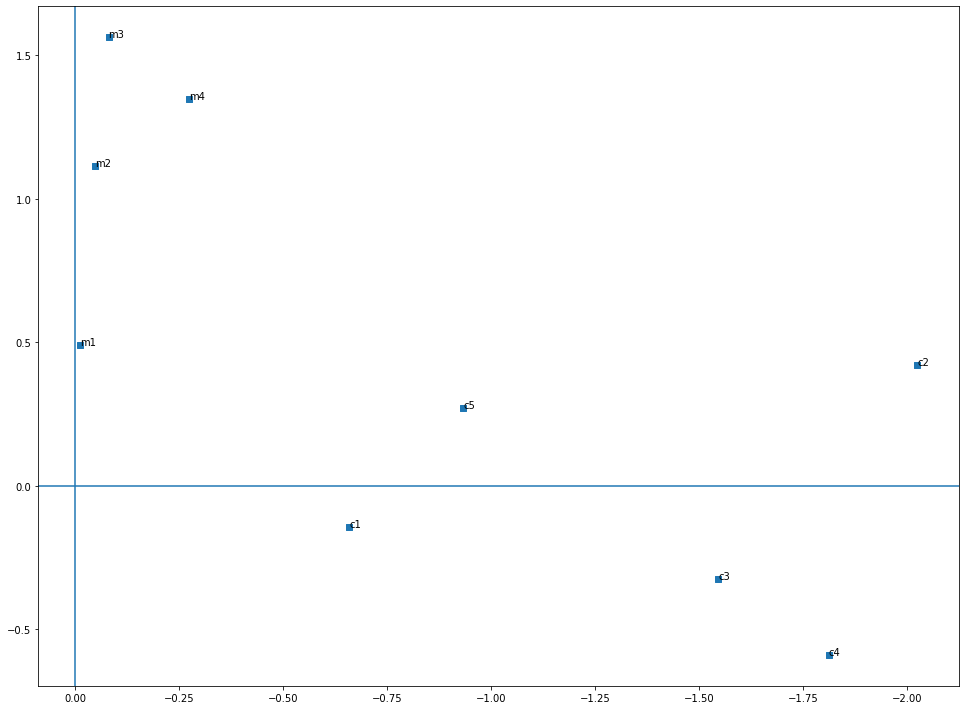

In [ ]:
# Visualize documents and print coordinates

print(Vk_t)

fig, ax = plt.subplots(figsize=(16.5, 12.5))
ax.scatter(Vk_t[:, 0], Vk_t[:, 1], marker='s')
for i, txt in enumerate(docName):
    ax.annotate(txt, (Vk_t[:, 0][i], Vk_t[:, 1][i]))

ax.invert_xaxis()
ax.axvline(x=0)
ax.axhline(y=0)
plt.show()

# Visualize terms in 2D space

[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]


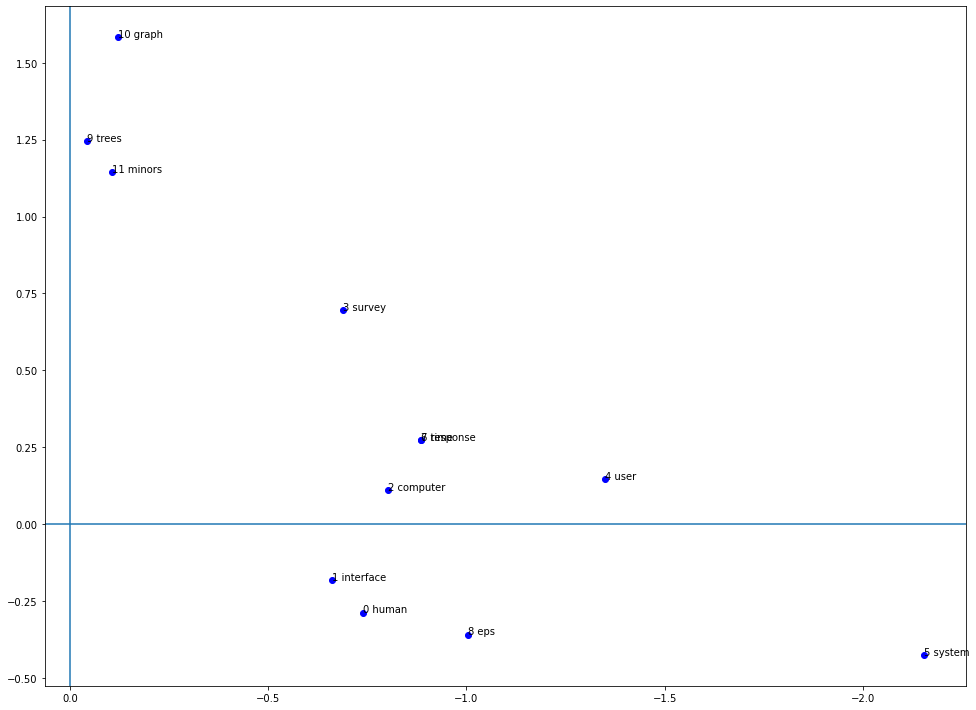

In [ ]:
# Visualize terms and print coordinates

print(Uk)

fig, ax = plt.subplots(figsize=(16.5, 12.5))
ax.scatter(Uk[:, 0], Uk[:, 1], c='blue')
for i, txt in enumerate(word_to_ix):
    ax.annotate(str(i) + " " + txt, (Uk[:, 0][i], Uk[:, 1][i]))

ax.invert_xaxis()
ax.axvline(x=0)
ax.axhline(y=0)
plt.show()

# Find matching documents for given document

In [ ]:
# Create query vector for input document and calculate its cosine distance from other documents

def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    """
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considered matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    """

    matches = []
    keyword_indices = np.zeros((len(word_to_ix)))
    word_list = preprocess(s)
    td_matrix = build_td_matrix(documents, word_to_ix)
    u, s, vh = np.linalg.svd(td_matrix)
    for j, word in enumerate(word_to_ix):
        if word in word_list:
            keyword_indices[j] = keyword_indices[j] + 1
    q_hat = np.dot(keyword_indices, u)[:2]
    dotVec = np.dot(Vk_t, Sk)
    temp = [1 - cosine(q_hat, x) for x in dotVec]
    for i, x in enumerate(temp):
        if x > min_score:
            matches.append((documents[i], x))

    return q_hat, matches

In [ ]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[-0.461821   -0.07002767]
[('Human machine interface for Lab ABC computer applications', 0.9999277969364698), ('A survey of user opinion of computer system response time', 0.9531386188769225), ('The EPS user interface management system', 0.9999728451095026), ('System and human system engineering testing of EPS', 0.9957638469318197), ('Relation of user-perceived response time to error measurement', 0.9330049385012567)]


# Visual representation of query/document

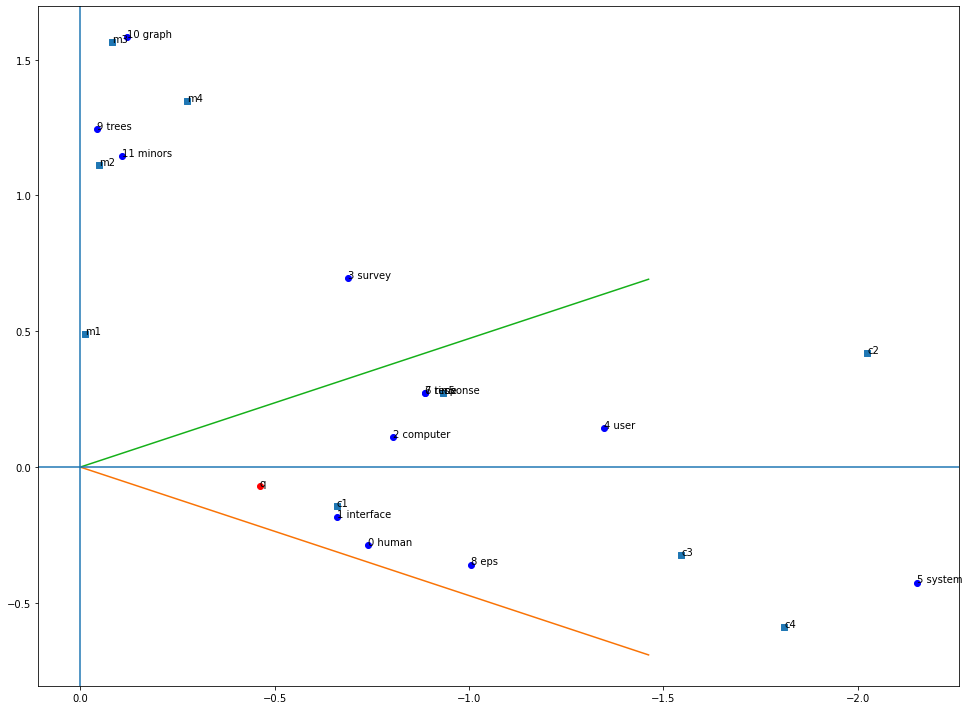

In [ ]:
# Plot terms, documents and query documents along with lines representing its cosine angle

fig, ax = plt.subplots(figsize=(16.5, 12.5))
x1 = y1 = 0
x2 = x3 = -1 + q_hat[0]
y2 = -1 * math.cos(.9) + q_hat[1]
y3 = -y2
x = [x1, x2]
y = [y1, y2]
ax.plot(x, y, c='#F97306')
a = [x1, x2]
b = [y1, y3]
ax.plot(a, b, c='#15B01A')
ax.scatter(q_hat[0], q_hat[1], c='red')
ax.annotate('q', (q_hat[0], q_hat[1]))
ax.scatter(Vk_t[:, 0], Vk_t[:, 1], marker='s')
for i, txt in enumerate(docName):
    ax.annotate(txt, (Vk_t[:, 0][i], Vk_t[:, 1][i]))
ax.scatter(Uk[:, 0], Uk[:, 1], c='blue')
for i, txt in enumerate(word_to_ix):
    ax.annotate(str(i) + " " + txt, (Uk[:, 0][i], Uk[:, 1][i]))

ax.invert_xaxis()
ax.axvline(x=0)
ax.axhline(y=0)
plt.show()

# n-Grams Language Models

The task is to train n-gram language models. Initially, train unigram, bigram, and trigram models on given training files. Then, score on given test files for unigram, bigram, and trigram. Finally, generate sentences from the trained model and compute perplexity.

In [ ]:
from collections import Counter
from nltk import tokenize
import numpy as np
import math
import random

In [ ]:
# constants to define pseudo-word tokens, access via UNK, and follow <s> tag for beginning of sentence and </s> for end of sentence

UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

# Initialise global variables for model

In [ ]:
"""
Initializes Parameters:
n_gram (int): the n-gram order.
is_laplace_smoothing (bool): whether or not to use Laplace smoothing
threshold: words with frequency  below threshold will be converted to token
"""

# Initializing different object attributes

n_gram = 2
is_laplace_smoothing = True
vocab = []
n_gram_counts = {}
n_minus_1_gram_counts = {}
threshold = 1

# Implement a function to make n-grams

In [ ]:
def make_ngrams(tokens: list, n: int) -> list:
    """
    Creates n-grams for the given token sequence.
    Input:
      Args: tokens (list): a list of tokens as strings n (int): the length of n-grams to create
    Output:
      list: list of tuples of strings, each tuple being one of the individual n-grams
    """

    n_grams = []
    for i in range(len(tokens) - n+1):
      n_grams.append(tuple((tokens[i:i+n])))

    return n_grams


# Implement the train function

In [ ]:
def train(training_file_path):
    """
    Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Input:
        training_file_path (str): the location of the training data to read
    Output:
      N Gram Counts, Vocab, N Minus 1 Gram Counts
    """

    content_list = []
    vocabCount = {}
    
    # Read and split data to get list of sentences
    
    with open(training_file_path, 'r') as fh:
        content = fh.read().split('\n')

    # Get the count of each word
    
    for sent in content:
        for word in sent.split(' '):
            content_list.append(word)
            if word in vocabCount.keys():
                vocabCount[word] = vocabCount[word] + 1
            else:
                vocabCount[word] = 1
                vocab.append(word)

    # Replace the words with <UNK> if count is < threshold(=1)
    
    for i in range(len(vocab)):
        if vocabCount[vocab[i]] <= threshold:
            vocab[i] = UNK

    # Make use of make_n_grams function
    
    n_grams = make_ngrams(content_list, n_gram)
    n_gram_counts = Counter(n_grams)

    # For n>1 grams compute n-1 gram counts to compute probability
    
    n_minus_1_gram_counts = {}
    if n_gram > 1:
        n_minus_1_grams = make_ngrams(content_list, n_gram - 1)
        n_minus_1_gram_counts = Counter(n_minus_1_grams)

    return n_gram_counts, vocab, n_minus_1_gram_counts

# Output the Trained Data Parameters

In [ ]:
n_gram_counts, vocab, n_minus_1_gram_counts = train("/content/drive/My Drive/NLP/Assignment_3/berp-training_bi.txt")
print(n_gram_counts)
print(vocab)

Counter({('</s>', '<s>'): 6755, ('', '</s>'): 1726, ('<s>', 'i'): 1646, ('like', 'to'): 953, ('i', 'want'): 743, ('to', 'eat'): 610, ('i', 'would'): 607, ('would', 'like'): 585, ('want', 'to'): 546, ('food', '</s>'): 521, ("i'd", 'like'): 495, ('<s>', "i'd"): 428, ('start', 'over'): 403, ('tell', 'me'): 390, ('to', 'go'): 294, ('<s>', 'tell'): 281, ('to', 'have'): 280, ('over', '</s>'): 264, ('me', 'about'): 252, ('dollars', '</s>'): 240, ('<s>', 'start'): 237, ('dollars', ''): 217, ('<s>', "let's"): 195, ('do', 'you'): 193, ('to', 'spend'): 187, ('dinner', '</s>'): 184, ('<s>', 'uh'): 183, ('show', 'me'): 178, ('<s>', "i'm"): 176, ('<s>', 'what'): 172, ("let's", 'start'): 170, ('i', "don't"): 167, ('<s>', 'do'): 165, ('<s>', 'can'): 159, ('restaurant', '</s>'): 157, ('more', 'than'): 151, ('give', 'me'): 151, ('food', ''): 149, ('<s>', 'the'): 147, ('information', 'about'): 145, ('can', 'you'): 143, ('less', 'than'): 136, ('can', 'i'): 135, ('lunch', '</s>'): 135, ('me', 'more'): 131,

# Implement the Scoring function

Score function will take input sentence and output probability of given string representing a single sentence.

In [ ]:
def score(sentence):
    """
    Calculates the probability score for a given string representing a single sentence.
    Input:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
    Output:
      float: the probability value of the given string for this model
    """

    # Split the input sentence and replace out of vocabulary tokens with <UNK>

    words = sentence.split(" ")
    for w in words:
        if w not in vocab:
            w = UNK
    sentence = sentence.split("\n")

    probability = 0
    
    # get n grams of sentence

    n_grams = make_ngrams(words, n_gram)

    # get n-1 ngrams if n_gram > 1

    if (n_gram > 1):
        n_minus_1_grams = make_ngrams(words, n_gram - 1)

    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    
    for n_grams_sent in n_grams:

        # Get count of various n grams generated by the sentence ex ('<s>', '<s>', 'a')
        
        n_grams_sent_count = n_gram_counts[n_grams_sent] if n_grams_sent in n_gram_counts.keys() else 0

        # Get count of the n-1 gram of every ngrams generated above  ex ('<s>', '<s>')
        
        n_minus_1_grams_sent_count = n_minus_1_gram_counts[n_grams_sent[0:-1]] if n_grams_sent[0:-1] in n_minus_1_gram_counts.keys() else 0

        # if laplace smoothing
        
        if is_laplace_smoothing:
            probability += math.log(n_grams_sent_count + 1) - math.log(n_minus_1_grams_sent_count + len(vocab))
        else:
            probability += math.log(n_grams_sent_count) - math.log(n_minus_1_grams_sent_count)

    return math.exp(probability)

In [ ]:
with open("/content/drive/My Drive/NLP/Assignment_3/hw2-test_bi.txt", 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probabilities = []

# of test sentences:  100


In [ ]:
# Print probabilities/score of sentences in test content

for sentence in test_content:
    probabilities.append(score(sentence))
probabilities = np.array(probabilities)
mean = np.mean(probabilities)
std_dev = np.std(probabilities)
print(mean)
print(std_dev)

1.871253985770829e-05
0.00011719336086306407


# Function for sentence generation

Generate sentence from the above trained model.

In [ ]:
def generate_sentence():
    """
    Generates a single sentence from a trained language model using the Shannon technique.
    Output:
      str: the generated sentence
    """

    # Start with <s> and randomly generate words until we encounter sentence end and keep track of previous word for stop condition
    
    prev_word = "<s>"
    
    sentence = []
    
    # Append sentence begin markers for n>2
    
    for i in range(n_gram - 1):
        sentence.append("<s>")
    if n_gram > 1:
        while prev_word != "</s>":
            next_word = []
            
            # Construct the (n-1) gram so far
            
            for k, v in n_gram_counts.items():
                if (tuple(sentence[-n_gram + 1:]) == k[:-1]):
                    
                    # Get the counts of all available choices based on n-1 gram
                    
                    for i in range(v):
                        next_word.append(k[-1:])

            # Apply random.choice() function on possible next words
            
            if (len(next_word) == 0):
                prev_word = "</s>"
            else:
                prev_word = random.choice(next_word)
                string = ''
            for item in prev_word:
                string = string + item
            prev_word = string

            # If "<s>" is generated ignore it
            
            if (string == "<s>"):
                pass
            else:
                sentence.append(string)

    else:
        
        # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
        
        while prev_word != "</s>":
            next_word = []
            
            # Construct the (n-1) gram so far
            
            for k, v in n_gram_counts.items():
                next_word.append(k)

            # Apply random.choice() function on possible next words
            
            if len(next_word) == 0:
                prev_word = "</s>"
            else:
                prev_word = random.choice(next_word)
            string = ''
            for item in prev_word:
                string = string + item
            prev_word = string

            # If "<s>" is generated ignore it
            
            if string == "<s>":
                pass
            else:
                sentence.append(string)
                
    # Append sentence end markers for n>2
    
    s = ' '.join([item for item in sentence])
    for i in range(n_gram - 2):
        s = s + " </s>"
    sentence = s

    return sentence

In [ ]:
def generate(n):
    """
    Generates n sentences from a trained language model using the Shannon technique.
    Input:
      n (int): the number of sentences to generate
    Output:
      list: a list containing strings, one per generated sentence
    """
    
    # Generate sentences one by one and store
    
    sentences = []
    for i in range(n):
        sentences.append(generate_sentence())
    return sentences

In [ ]:
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
    print(sentence)

Sentences:
<s> cafe christopher's cafe </s>
<s> now so the best not breakfast on mondays </s>
<s> um metropole </s>
<s> can you know a sandwich places </s>
<s> not cost to have much  </s>
<s> sorry ethiopian food </s>
<s> i would like to have dinner </s>
<s> i would like to go to spend  </s>
<s> not thai food  </s>
<s> what about the skates  </s>
<s> the distance </s>
<s> money does not plearn's please </s>
<s> i have dinner and i wannu eat at a bar and bagel </s>
<s> start over </s>
<s> friday </s>
<s> not familiar with a japanese restaurants open on russell street a fancy restaurant  </s>
<s> an hour </s>
<s> spanish food </s>
<s> i want some lunch </s>
<s> ten miles give me </s>
<s> can get a greek  </s>
<s> i would like the cross street  </s>
<s> i want it on shattuck from icsi and </s>
<s> this afternoon should i wanna go up  </s>
<s> i want to eight o'clock p__m </s>
<s> i'd like to ten bucks  </s>
<s> i'd like to travel a french food restaurant around twenty dollars  </s>
<s> ab

# Evaluate model perplexity

Measures the perplexity for the test sequence with the trained model. The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words. Since this sequence will cross many sentence boundaries, include the beginning- and end-sentence markers \<s\> and \<\/s> in the probability computation. Also, include the end-of-sentence marker \<\/s> but not the beginning-of-sentence marker \<s\> in the total count of word tokens N.

In [ ]:
def perplexity(test_sequence):
    """
    Input:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity
    Output:
      float: the perplexity of the given sequence
    """

    # Replace out of vocab words with <UNK>

    N = 0
    test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]
    dummy = " ".join(test_sequence)
    for word in test_sequence:
        if word != "<s>":
            N = N + 1

    # Get the probability for the sequence

    probability = score(dummy)
    perplexity = (1 / probability) ** (1 / N)

    return perplexity

In [ ]:
print(perplexity(" ".join(sentences[0:10])))

72.87328127373519


# Classification using LSTM

This part consists of building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.

# Library Imports

In [ ]:
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import string
import re
import nltk

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Visualizing data distribution


In [ ]:
# Reading the data and removing columns that are not important.

dataset = pd.read_csv("/content/drive/My Drive/NLP/Assignment_3/movie_reviews.csv", sep=',', encoding='latin-1',
                      usecols=lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
# Print head of data frame with help of head function

dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


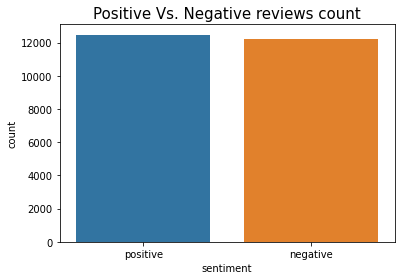

In [ ]:
# Plot Positive Vs. Negative reviews count

sns.countplot(dataset.sentiment)
plt.title("Positive Vs. Negative reviews count", fontsize=15)
plt.show()

# Cleaning the Reviews

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed) if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [ ]:
# Clean all the reviews in the dataset using the clean_text function provided above

dataset.review = dataset.review.apply(clean_text)

In [ ]:
# Print head of the "CLEANED" data frame with help of head function

dataset.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,petter matteis love time money visually stunni...,positive
4,probably alltime favorite movie story selfless...,positive


# Splitting the dataset and Encoding Labels

80% for the training and the remaining 20% for validation. Encode labels as negative and positive as 0 and 1 respectively


In [ ]:
# Split the data using into 80% train and 20% validation

train_sentences, test_sentences, train_labels, test_labels = train_test_split(dataset.review, dataset.sentiment,
                                                                              train_size=0.8)

In [ ]:
# Initialize label encoder and fit_transform on train labels and transform validation labels

le = LabelEncoder()
train_labels = le.fit_transform(train_labels.tolist())
test_labels = le.transform(test_labels.tolist())

# Pre-Processing The Text
 

In [ ]:
# Fit tokenizer on the training reviews

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

# Create the word_index dictionary using the tokenizer and find the vocabulary of training reviews

word_index = tokenizer.word_index
vocabulary = len(word_index) + 1

# Convert the reviews in the dataset to their index form by using a function available with the tokenizer

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Pad the the training and validation sequences so all of them have the same length

train_padded = pad_sequences(train_sequences, padding='post', maxlen=200)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=200)

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : 99906


# Use GloVe vectors for embedding

GloVe vectors capture both global statistics and local statistics of a corpus. Use GloVe to convert words to embeddings in the vector space based on their semantics. The 200-dimensional GloVe vectors for the task at hand.

In [ ]:
glove_dictionary = {}
with open('/content/drive/My Drive/NLP/Assignment_3/glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(), dtype=float)
        glove_dictionary[words_in_line] = coeff_cients

In [ ]:
# All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((vocabulary, 200))

# Create the embedding matrix using the glove_dictionary 

for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(99906, 200)

# Create the LSTM model

In [ ]:
tf.random.set_seed(42)

def build_model(embedding_matrix):
    """
    Input:
      embedding_matrix : a matrix with the corresponding embeddings
                        of all words.
    Output:
      The LSTM model that you created.
    """

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocabulary, 200, weights=[embedding_matrix], input_length=200, trainable=False))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

    model.add(tf.keras.layers.Dense(24, activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

    return model

In [ ]:
# Call the build_model function and initialize the model

model = build_model(embedding_matrix)

# Train and validate the model on the padded sequences of text

history = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
618/618 [==============================] - 143s 224ms/step - loss: 0.5292 - auc: 0.8130 - precision: 0.7480 - recall: 0.7267 - accuracy: 0.7392 - val_loss: 0.4544 - val_auc: 0.8846 - val_precision: 0.7839 - val_recall: 0.8766 - val_accuracy: 0.8132
Epoch 2/5
618/618 [==============================] - 137s 221ms/step - loss: 0.3912 - auc: 0.9046 - precision: 0.8246 - recall: 0.8361 - accuracy: 0.8280 - val_loss: 0.3432 - val_auc: 0.9295 - val_precision: 0.8580 - val_recall: 0.8485 - val_accuracy: 0.8506
Epoch 3/5
618/618 [==============================] - 137s 221ms/step - loss: 0.3278 - auc: 0.9338 - precision: 0.8526 - recall: 0.8698 - accuracy: 0.8587 - val_loss: 0.3411 - val_auc: 0.9382 - val_precision: 0.8060 - val_recall: 0.9288 - val_accuracy: 0.8492
Epoch 4/5
618/618 [==============================] - 137s 222ms/step - loss: 0.2925 - auc: 0.9473 - precision: 0.8703 - recall: 0.8859 - accuracy: 0.8761 - val_loss: 0.3181 - val_auc: 0.9387 - val_precision: 0.8758 - val_re

# Plotting Accuracy and Losses

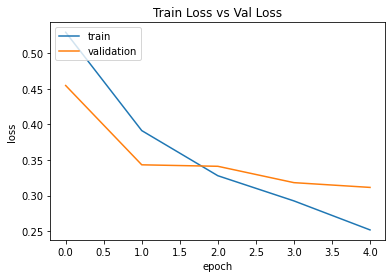

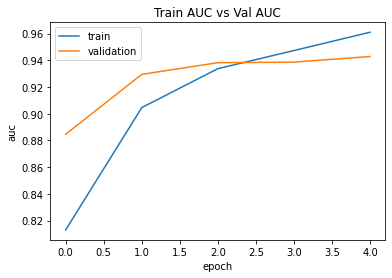

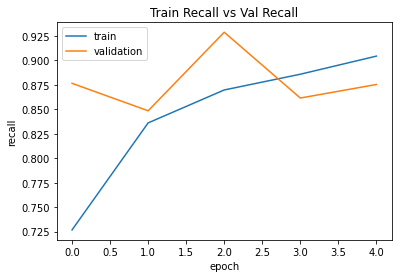

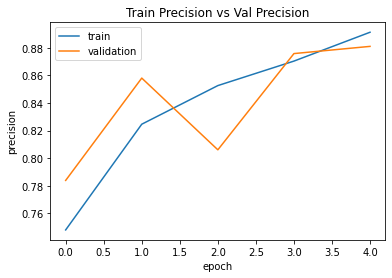

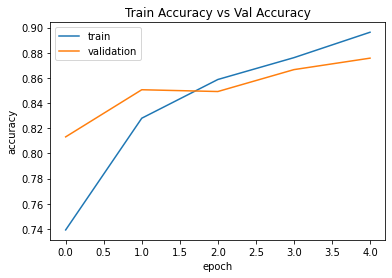

In [ ]:
# PLOT train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision, and train accuracy vs val accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train Loss vs Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Train AUC vs Val AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Train Recall vs Val Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Train Precision vs Val Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train Accuracy vs Val Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the trained model as a pickle file named "lstm_classifier" to use it to make predictions

pickle.dump(model, open('/content/drive/My Drive/NLP/Assignment_3/lstm_classifier.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://1a56c762-d5be-426b-8be5-a7e1e9d6f64d/assets


INFO:tensorflow:Assets written to: ram://1a56c762-d5be-426b-8be5-a7e1e9d6f64d/assets


# Prediction

In [ ]:
# Load your saved model to make predictions

saved_model = pickle.load(open('/content/drive/My Drive/NLP/Assignment_3/lstm_classifier.pkl', 'rb'))

In [ ]:
# Use the saved model to predict the reviews

def predict_review(review):
    """
    Input:
      review : A single review for which you want to predict the sentiment for.
              example: "This movie was amazing! I would definitely watch it again."
    Output:
      The predicted sentiment for the review : either 1 or 0
    """

    # Predict the sentiment for the given review using the model and return the sentiment                                 

    sequences = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(sequences, padding='post', maxlen=200)
    prediction = saved_model.predict(padded)
    if prediction >= 0.5:
        prediction = 1
    else:
        prediction = 0

    return prediction

In [ ]:
for review in [
    "If you like original gut-wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
    "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
    "I have seen this film at least 100 times, and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
    "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as non-entertaining, non-instructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')

If you like original gut-wrenching laughter you will like this movie. If you are young or old then y -> 1
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0
I have seen this film at least 100 times, and I am still excited by it, the acting is perfect and th -> 1
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0
